# Flattening and Folding for Optimization and Frequentist Covariances.

In [1]:
import autograd
from autograd import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import paragami

# Use the original scipy ("osp") for functions we don't need to differentiate.
# When using scipy functions in functions that are passed to autograd,
# use autograd.scipy instead.
import scipy as osp

## Using Flattening and Folding for Optimization.

### An Example Model.

Suppose we are interested in optimizing some function of $A$, say, a normal model in which the data $x_n \sim \mathcal{N}(0, A)$.  Specifically, Let the data be $X = \left(x_1, ..., x_N\right)$, where $x_n \in \mathbb{R}^3$, and write a loss function as

$$
\ell\left(X, A\right) =
    -\sum_{n=1}^N \log P(x_n | A) =
    \frac{1}{2}\sum_{n=1}^N \left(x_n^T A^{-1} x_n - \log|A|\right) 
$$

Let's simulate some data under this model.

In [13]:
np.random.seed(42)

num_obs = 100

# True value of A
true_a = np.eye(3) * np.diag(np.array([1, 2, 3])) + np.random.random((3, 3)) * 0.1
true_a = 0.5 * (true_a + true_a.T)

# Data
def draw_data(num_obs, true_a):
    return np.random.multivariate_normal(
        mean=np.zeros(3), cov=true_a, size=(num_obs, ))

x = draw_data(num_obs, true_a)
print('X shape: {}'.format(x.shape))

X shape: (100, 3)


We can estimate the covariance matrix using the negative log likelihood as a loss function.

In [14]:
def get_loss(x, a):
    num_obs = x.shape[0]
    a_inv = np.linalg.inv(a)
    a_det_sign, a_log_det = np.linalg.slogdet(a)
    assert a_det_sign > 0
    return 0.5 * (np.einsum('ni,ij,nj', x, a_inv, x) + num_obs * a_log_det)

print('Loss at true parameter: {}'.format(get_loss(x, true_a)))

Loss at true parameter: 242.28536625488033


### Using ``autograd`` and ``scipy.optimize`` with ``paragami``.

We would like to minimize the function `loss` using tools like `scipy.optimize.minimize`.  Standard optimization functions take vectors, not matrices, as input, and often require the vector to take valid values in the entire domain.

As-written, our loss function takes a positive definite matrix as an input.  We can wrap the loss as a funciton of the free flattened value using the `paragami.FlattenFunctionInput` class.  That is, we want to define a function $\ell_{freeflat}$ so that

$$
\ell_{freeflat}(X, A_{freeflat}) = \ell(X, A).
$$


In [17]:
a_pattern = paragami.PSDSymmetricMatrixPattern(size=3)

# The arguments mean we're flatting the function get_loss, using
# the pattern a_pattern, with free parameterization, and the paramater
# is the second one (argnums uses 0-indexing like autograd).
get_freeflat_loss = paragami.FlattenFunctionInput(
    original_fun=get_loss, patterns=a_pattern, free=True, argnums=1)

print('The two losses are the same when evalated on the folded and flat values:\n')
print('Original loss:\t\t{}'.format(get_loss(x, true_a)))
true_a_freeflat = a_pattern.flatten(true_a, free=True)
print('Free-flattened loss: \t{}'.format(
    get_freeflat_loss(x, true_a_freeflat)))

The two losses are the same when evalated on the folded and flat values:

Original loss:		242.28536625488033
Free-flattened loss: 	242.28536625488036


The resulting function can be passed directly to `autograd` and `scipy.optimize`, and we can estimate

$$
\hat{A}_{freeflat} := \mathrm{argmin}_{A_{freeflat}} \ell_{freeflat}(X, A_{freeflat}).
$$

Note that (as of writing) ``A bad approximation caused failure to predict improvement`` errors are common with second order methods even when optimization was successful.  This is because  ``osp.optimize.minimize`` only uses the norm of the gradient before multiplication by the inverse Hessian as a convergence criterion.

In [26]:
get_freeflat_loss_grad = autograd.grad(get_freeflat_loss, argnum=1)
get_freeflat_loss_hessian = autograd.hessian(get_freeflat_loss, argnum=1)

def get_optimum(x, init_val):
    loss_opt = osp.optimize.minimize(
        method='trust-ncg',
        x0=init_val,
        fun=lambda par: get_freeflat_loss(x, par),
        jac=lambda par: get_freeflat_loss_grad(x, par),
        hess=lambda par: get_freeflat_loss_hessian(x, par),
        options={'gtol': 1e-8, 'disp': False})
    return loss_opt

init_val = np.zeros(a_pattern.flat_length(free=True))
loss_opt = get_optimum(x, init_val)

print('Optimization status: {}\nOptimal value: {}'.format(
      loss_opt.message, loss_opt.fun))

Optimization status: A bad approximation caused failure to predict improvement.
Optimal value: 239.37556057055355


The optimization was in the free flattened space, so to get the optimal value of $A$ we must fold it.   We can see that the optimal value is close to the true value of $A$, though it differs due to randomness in $X$.

In [27]:
optimal_freeflat_a = loss_opt.x
optimal_a = a_pattern.fold(optimal_freeflat_a, free=True)
print('True a:\n{}\n\nOptimal a:\n{}'.format(true_a, optimal_a))

True a:
[[1.03745401 0.07746864 0.03950388]
 [0.07746864 2.01560186 0.05110853]
 [0.03950388 0.05110853 3.0601115 ]]

Optimal a:
[[ 1.13076002 -0.16382566  0.18449819]
 [-0.16382566  1.97854146  0.3020592 ]
 [ 0.18449819  0.3020592   2.78831733]]


## Using Flattening and Folding with the Fisher Information for Frequentist Uncertainty.

### Fisher Information and the Delta Method.

Suppose we wanted to use the Hessian of the objective (the observed Fisher information) to estimate a frequentist confidence region for $A$.  In standard notation, covariance is of a vector, so we can write what we want in terms of $A_{flat}$ as $\mathrm{Cov}(A_{flat})$.
The covariance between two elements of $A_{flat}$ corresponds to that between two elements of $A$.  For example, using the notation given above,

$$
\mathrm{Cov}(a_{flat,1}, a_{flat,2}) = \mathrm{Cov}(a_{11}, a_{12}) = \mathrm{Cov}(a_{11}, a_{21})\\
\mathrm{Var}(a_{flat,4}) = \mathrm{Var}(a_{21}) = \mathrm{Var}(a_{12}),
$$
etc.

Here, we will use the observed Fisher information of $\ell_{freeflat}$ and the Delta method to estimate $\mathrm{Cov}(A_{flat})$.

$$
\begin{aligned}
\mathrm{Cov}(A_{freeflat}) &\approx
-\left( \left.
\frac{\partial^2 \ell_{freeflat}}{\partial A_{freeflat} \partial A_{freeflat}^T}
\right|_{\hat{A}_{freeflat}} \right)^{-1}
&\quad\textrm{(Fisher information)}
\\
\mathrm{Cov}(A_{free}) &\approx
\left(\frac{d A_{free}}{dA_{freeflat}^T}\right)
\mathrm{Cov}(A_{freeflat})
\left(\frac{d A_{free}}{dA_{freeflat}^T}\right)^T
&\quad\textrm{(Delta method)}
\end{aligned}
$$

The Hessian required for the covariance can be calculated directly using ``autograd``.  (Note that the loss is the negative of the log likelihood.)  The shape is, of course, the size of $A_{freeflat}$.

In [5]:
fisher_info = -1 * get_freeflat_loss_hessian(x, loss_opt.x)
print("The shape of the Fisher information amtrix is {}.".format(fisher_info.shape))

The shape of the Fisher information amtrix is (6, 6).


The Jacobian matrix $\frac{d A_{free}}{dA_{freeflat}^T}$ of the "unfreeing transform" $A_{free} = A_{free}(A_{freeflat})$ is provided by ``paragami`` as a function of the *folded* parameter.  Following standard notation for Jacobian matrices, the rows correspond to $A_{flat}$, the output of the unfreeing transform, and the columns correspond to $A_{freeflat}$, the input to the unfreeing transform.

By default this Jacobian matrix is sparse (in large problems, most flat parameters are independent of most free flat parameters), but a dense matrix is fine in this small problem, so we use ``sparse=False``.



In [6]:
freeing_jac = a_pattern.unfreeing_jacobian(optimal_a, sparse=False)
print("The shape of the Jacobian matrix is {}.".format(freeing_jac.shape))

The shape of the Jacobian matrix is (9, 6).


We can now plug in to estimate the covariance.

In [7]:
# Estimate the covariance of the flattened value using the Hessian at the optimum.
a_flattened_cov = -1 * freeing_jac @ np.linalg.solve(fisher_info, freeing_jac.T)


### A Cautionary Note on Using the Fisher Information With Constrained Variables.

Note that the estimated covariance is rank-deficient.  This is expected, since, for example, $A_{12}$ and $A_{21}$ cannot vary independently.


In [8]:
print('The shape of the covariance matrix is {}.'.format(a_flattened_cov.shape))
print('The rank of the covariance matrix is {}.'.format(np.linalg.matrix_rank(a_flattened_cov)))

The shape of the covariance matrix is (9, 9).
The rank of the covariance matrix is 6.


Suppose we had erronously defined the function $\ell_{flat}(A_{flat})$ and tried to estimate the covariance of $A$ using the Hessian of $\ell_{flat}$.  Then the resulting Hessian would have been *full rank*, because the loss function ``get_loss`` does not enforce the constraint that $A$ be symmetric.  

In [9]:
print('An example of an erroneous use of Fisher information!')
get_flat_loss = paragami.FlattenFunctionInput(
    original_fun=get_loss, patterns=a_pattern, free=False, argnums=1)
get_flat_loss_hessian = autograd.hessian(get_flat_loss, argnum=1)
a_flat_opt = a_pattern.flatten(optimal_a, free=False)
bad_fisher_info = get_flat_loss_hessian(x, a_flat_opt)

bad_a_flattened_cov = -1 * np.linalg.inv(bad_fisher_info)

print('The shape of the erroneous covariance matrix is {}.'.format(bad_a_flattened_cov.shape))
print('The rank of the erroneous covariance matrix is {}.'.format(np.linalg.matrix_rank(bad_a_flattened_cov)))

An example of an erroneous use of Fisher information!
The shape of the erroneous covariance matrix is (9, 9).
The rank of the erroneous covariance matrix is 9.


Theoretically, we are not justified using the Hessian of $\ell_{flat}$ to estimate the covariance of its optimizer because the optimum is not "interior" -- that is, the argument $A_{flat}$ cannot take legal values in a neighborhood of the optimum, since such values may not be valid covariance matrices.  Overcoming this difficulty is a key advantage of using unconstrained parameterizations.

### Inspecting and Checking the Result.

This shape of $\mathrm{Cov}(A_{flat})$ is inconvenient because it's not obvious visually which entry of the flattened vector corresponds to which element of $A$.  Again, we can use folding to put the estimated marginal standard deviations in a readable shape.

Because the result is not a valid covariance matrix, and we are just using the pattern for its shape, we set `validate` to `False`.

In [10]:
a_pattern.verify = False
a_sd = a_pattern.fold(np.sqrt(np.diag(a_flattened_cov)), free=False, validate_value=False)
print('The marginal standard deviations of the elements of A:\n{}'.format(a_sd))

The marginal standard deviations of the elements of A:
[[0.15991362 0.15046908 0.17852051]
 [0.15046908 0.27980802 0.23681303]
 [0.17852051 0.23681303 0.39432762]]


As a sanity check, we can compare this estimated covariance with the variability incurred by drawing new datasets and re-optimizing.

In [11]:
num_sims = 20
optimal_a_draws = np.empty((num_sims, ) + true_a.shape)
for sim in range(num_sims):
    new_x = draw_data(num_obs, true_a)
    new_loss_opt = get_optimum(new_x)
    optimal_a_draws[sim] = a_pattern.fold(new_loss_opt.x, free=True)

Actual standard deviation:
[[0.12203849 0.11104834 0.13347622]
 [0.11104834 0.25363392 0.24355346]
 [0.13347622 0.24355346 0.50647563]]
Estimated standard deviation:
[[0.15991362 0.15046908 0.17852051]
 [0.15046908 0.27980802 0.23681303]
 [0.17852051 0.23681303 0.39432762]]


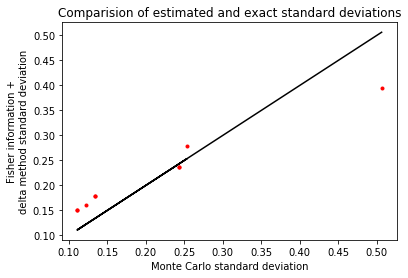

In [12]:
a_sd_monte_carlo = np.std(optimal_a_draws, axis=0)

plt.plot(a_sd_monte_carlo.flatten(), a_sd.flatten(), 'r.')
plt.plot(a_sd_monte_carlo.flatten(), a_sd_monte_carlo.flatten(), 'k')
plt.xlabel('Monte Carlo standard deviation')
plt.ylabel('Fisher information +\ndelta method standard deviation')
plt.title('Comparision of estimated and exact standard deviations')

print('Actual standard deviation:\n{}'.format(a_sd_monte_carlo))
print('Estimated standard deviation:\n{}'.format(a_sd))